# Predicciones con Word2Vec

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nlp_helpers
from nltk.corpus import stopwords
import os
import pickle

In [4]:
embedding_size = 200
vocabulary_size = 2000
batch_size = 100
max_words = 100
stops = stopwords.words('english')

In [5]:
texts, target = nlp_helpers.load_movies_data()
texts = nlp_helpers.normalize_text(texts, stops)

In [6]:
target = [target[ix] for ix, x in enumerate(texts) if len(x.split())>2]
texts = [x for x in texts if len(x.split())>2]

In [7]:
train_idx = np.random.choice(len(target), round(0.8*len(target)), replace=False)
test_idx = np.array(list(set(range(len(target)))-set(train_idx)))

In [15]:
texts_train = [x for ix, x in enumerate(texts) if ix in train_idx]
texts_test = [x for ix, x in enumerate(texts) if ix in test_idx]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_idx])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_idx])

In [17]:
dict_file = os.path.join("../../datasets", "movie_vocabulary.pkl")
word_dictionary = pickle.load(open(dict_file, 'rb'))

In [18]:
word_dictionary

{'collection': 1566,
 'fully': 718,
 'fair': 1298,
 'creates': 669,
 'wait': 1053,
 'extreme': 763,
 'movies': 17,
 'reach': 1349,
 'depiction': 1464,
 'huge': 985,
 'found': 412,
 'burns': 1438,
 'novel': 459,
 'flashy': 1719,
 'slick': 1471,
 'vision': 559,
 'turning': 1792,
 'expect': 523,
 'appear': 1832,
 'scripts': 1702,
 'devastating': 1903,
 'personality': 1470,
 'cult': 1652,
 'queen': 1313,
 'direction': 191,
 'played': 853,
 'ending': 255,
 'intensity': 1525,
 'deserves': 639,
 'jack': 1678,
 'blade': 1034,
 'favor': 1324,
 'b': 1362,
 'compelling': 135,
 'one': 3,
 'fails': 333,
 'grace': 764,
 'special': 162,
 'funnier': 1086,
 'generation': 1113,
 'ensemble': 633,
 'impressive': 584,
 'false': 1664,
 'delivering': 1993,
 'imagination': 514,
 'across': 684,
 'appealing': 577,
 'superb': 1920,
 'weight': 1273,
 'frida': 1685,
 'strength': 1126,
 'entire': 517,
 'check': 1412,
 'polished': 1587,
 'stylish': 762,
 'divine': 1980,
 'role': 367,
 'sympathy': 1595,
 'fable': 141

In [19]:
text_data_train = np.array(nlp_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(nlp_helpers.text_to_numbers(texts_test, word_dictionary))

In [20]:
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

In [21]:
A = tf.Variable(tf.random_normal(shape = [embedding_size, 1]))
b = tf.Variable(tf.random_normal(shape = [1,1]))

x_data = tf.placeholder(shape = [None, max_words], dtype = tf.int32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

In [22]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

In [23]:
embed = tf.nn.embedding_lookup(embeddings, x_data)
embed_avg = tf.reduce_mean(embed,1)

In [24]:
model_output = tf.add(tf.matmul(embed_avg, A), b)

In [25]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [26]:
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [27]:
my_optim = tf.train.AdagradOptimizer(0.005)
train_step = my_optim.minimize(loss)

In [29]:
session = tf.Session()
init = tf.global_variables_initializer()
session.run(init)

In [30]:
model_checkpoint_path = os.path.join("../../datasets", "cbow_movie_embeddings.ckpt")
saver = tf.train.Saver({"embeddings": embeddings})
saver.restore(session, model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../../datasets/cbow_movie_embeddings.ckpt


In [31]:
session.run(embeddings)

array([[ 0.47691995, -0.7063197 ,  0.4997867 , ...,  1.2257141 ,
         0.44793314,  0.3869213 ],
       [ 0.09285235, -0.5890758 , -0.8968625 , ..., -0.75183487,
        -0.1856513 ,  0.5376508 ],
       [ 0.70859647, -0.04537868,  0.06115341, ...,  0.1705215 ,
         0.39041996,  0.57622504],
       ...,
       [ 0.67241955,  0.72852874, -0.46823454, ..., -0.3701911 ,
         0.88134   ,  0.99436426],
       [ 0.31050444,  0.1812253 , -0.2252047 , ..., -0.07675552,
         0.20896816, -0.5758445 ],
       [ 0.97421   ,  0.247648  , -0.8632951 , ...,  0.71806765,
        -0.7972245 , -0.6214726 ]], dtype=float32)

In [33]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []

for i in range(10000):
    rand_idx = np.random.choice(text_data_train.shape[0], size = batch_size)
    rand_x = text_data_train[rand_idx]
    rand_y = np.transpose([target_train[rand_idx]])
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    if(i+1)%100==0:
        i_data.append(i+1)
        
        train_loss_temp = session.run(loss, feed_dict={x_data: rand_x, y_target:rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = session.run(loss, feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = session.run(accuracy, feed_dict={x_data: rand_x, y_target:rand_y})
        train_acc.append(train_acc_temp)
        
        test_acc_temp = session.run(accuracy, feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
        
    if(i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Paso #{}, Train Loss {}, Test Loss {}. Train Acc {}, Test Acc{}".format(*acc_and_loss))

Paso #500, Train Loss 0.6840000152587891, Test Loss 0.6949999928474426. Train Acc 0.5099999904632568, Test Acc0.49300000071525574
Paso #1000, Train Loss 0.6859999895095825, Test Loss 0.6949999928474426. Train Acc 0.5600000023841858, Test Acc0.5009999871253967
Paso #1500, Train Loss 0.6859999895095825, Test Loss 0.6949999928474426. Train Acc 0.5400000214576721, Test Acc0.5019999742507935
Paso #2000, Train Loss 0.6859999895095825, Test Loss 0.6940000057220459. Train Acc 0.5799999833106995, Test Acc0.4950000047683716
Paso #2500, Train Loss 0.6930000185966492, Test Loss 0.6940000057220459. Train Acc 0.550000011920929, Test Acc0.5099999904632568
Paso #3000, Train Loss 0.703000009059906, Test Loss 0.6940000057220459. Train Acc 0.4399999976158142, Test Acc0.5040000081062317
Paso #3500, Train Loss 0.6990000009536743, Test Loss 0.6940000057220459. Train Acc 0.4699999988079071, Test Acc0.5090000033378601
Paso #4000, Train Loss 0.6990000009536743, Test Loss 0.6949999928474426. Train Acc 0.5199999

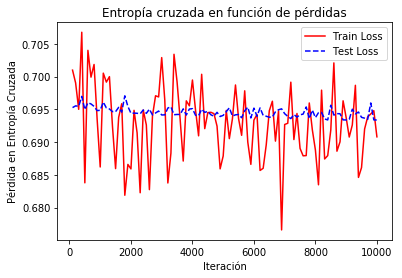

In [34]:
plt.plot(i_data, train_loss, 'r-', label="Train Loss")
plt.plot(i_data, test_loss, 'b--', label="Test Loss")
plt.title("Entropía cruzada en función de pérdidas")
plt.xlabel("Iteración")
plt.ylabel("Pérdida en Entropía Cruzada")
plt.legend(loc = "upper right")
plt.show()

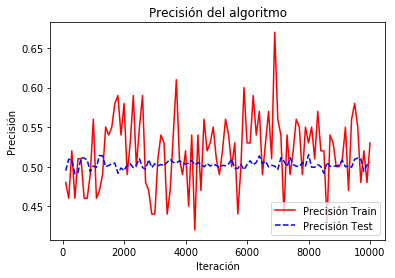

In [35]:
plt.plot(i_data, train_acc, 'r-', label="Precisión Train")
plt.plot(i_data, test_acc, 'b--', label="Precisión Test")
plt.title("Precisión del algoritmo")
plt.xlabel("Iteración")
plt.ylabel("Precisión")
plt.legend(loc = "lower right")
plt.show()